In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import time

### Load the dataset.
We take out a bunch of examples for our network.  The whole dataset contains 1 million training examples and 100.000 test examples. We only use the first 100.000 examples from the "train" data for training and the first 1000 examples from the "test" data for testing and store them in separate variables.

In [ ]:
# Load dataset in batch sizes
train_rawdata, test_rawdata = tfds.load('genomics_ood', split=['train[:80%]', 'train[80%:]'], as_supervised=True)
# Only take a sample of the whole dataset
train_rawdata = train_rawdata.take(100000)
test_rawdata = test_rawdata.take(1000)

Let's see if we can get insights into the shape and data types of the components of our loaded datasets' elements...

In [ ]:
# We can inspect properties of our freshly loaded datasets
print(train_rawdata.element_spec)
print(str(test_rawdata.element_spec) + "\n")

# We will see that we cannot inspect the shape of the gene-sequence and target labels in our data yet.
# This is so, because we loaded the dataset as a Prefetch-Dataset.
# We may gain insights into the elements' shape after operating on them in the preprocessing step (scroll down).
print("Shapes and data types of the gene-sequence and target class labels after loading:")
# try to take one sample from our training data and inspect(print) the shape of its components
for sequence, target in train_rawdata.take(1):
  print("Training data:")
  print("gene sequence shape: " + str(sequence.shape) + ", " + str(sequence.dtype))
  print("target label: " + str(target.shape) + ", " + str(target.dtype))
# do the same for the test data
for sequence, target in test_rawdata.take(1):
  print("Test data:")
  print("gene sequence: " + str(sequence.shape) + ", " + str(sequence.dtype))
  print("target label: " + str(target.shape) + ", " + str(target.dtype))

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))

Shapes and data types of the gene-sequence and target class labels after loading:
Training data:
gene sequence shape: (), <dtype: 'string'>
target label: (), <dtype: 'int64'>
Test data:
gene sequence: (), <dtype: 'string'>
target label: (), <dtype: 'int64'>


### Preprocess the dataset.

The genomic sequences come as string-tensor (as we saw above) which are not so handy to work with. Instead, we would like to have the genomic sequence with one-hot-vectors for encoding the nucleotides (A, C, G, T). But because the sequences are string tensors, we cannot simply call tf.onehot (x, 4) on them.  

Therefore, we define a function which converts the string tensor (containing the gene sequence) into a usable tensor that contains the one-hot-encoded sequence.

In [ ]:
# function that yields a tensor with onehot number encodings for the 
# gene-sequence-string input tensor (as loaded from the genomics_ood dataset)
def onehotify(geneseq):
  # dict containing mappings from strings {A,C,G,T} to numbers {1,2,3,0}
  string_mapping = {"A": "0", "C": "1", "G": "2", "T": "3"}
  # iterate over the key(=string) elements in the dict
  for key in string_mapping.keys():
    # in the geneseq tensor, replace all matches of each string-key 
    # from the string_mapping dictionaryin with its associated value(number)
    geneseq = tf.strings.regex_replace(geneseq, key, string_mapping[key])
  # split resulting strings in the tensor into bytes
  splitted_geneseq = tf.strings.bytes_split(geneseq)
  # cast the splitted string elements in the tensor to numeric dtype
  numeric_geneseq = tf.cast(tf.strings.to_number(splitted_geneseq), tf.uint8)
  # create a onehot encoded sequence from the now numeric input
  # use a depth of 4, since each element is one of {0,1,2,3} (4 possible values)
  geneseq_onehot = tf.one_hot(numeric_geneseq, 4)
  # in the end we need the tensor as only one row
  # -1 means that the length in that dimension is inferred, while the number of 
  # elements must remain the same
  geneseq_onehot = tf.reshape(geneseq_onehot, (-1,))
  # return the string-element-wise now one-hot encoded numeric tensor
  return geneseq_onehot

### Build the TensorFlow dataset: Input pipeline

Now we can convert the loaded data into a usable (one-hot encoded vector) format for our network. For each of the loaded samples in the training and testing dataset, we apply our conversion function from above to the gene_sequence part of the sample and use the pre-defined tf.one_hot function for one-hot encoding the target class labels.

In [ ]:
# Map to onehotvectors
train_ds = train_rawdata.map(lambda x, y: (onehotify(x), tf.one_hot(y, 10)))
test_ds = test_rawdata.map(lambda x, y: (onehotify(x), tf.one_hot(y, 10)))

Now we can again have a look at the components of our datasets after preprocessing, since the shape of the gene sequence and the target labels should have changed by the preprocessing. To control this, we again take one sample from the training and test datasets, each.



In [ ]:
# make sure whether we are still dealing with instances of tf.data.Dataset after all our operations
assert isinstance(train_ds, tf.data.Dataset)
assert isinstance(test_ds, tf.data.Dataset)

# Inspect the properties of our datasets again
print(train_ds.element_spec)
print(str(test_ds.element_spec) + "\n")

# Inspect the shape and data types of the gene-sequence and target labels after preprocessing
print("Shapes and data types of the gene-sequence and target class labels after preprocessing:")

for sequence, target in train_ds.take(1):
  print("Training data:")
  # should be 250 (no. original string elements) * 4 (numeric one-hot encodig) = 1000
  print("One-hot encoded gene sequence: " + str(sequence.shape)+ ", " + str(sequence.dtype))
  # should be 10 (one-hot encoding of the 10 different class labels)
  print("One-hot encoded target label: " + str(target.shape)+ ", " + str(target.dtype))

for sequence, target in test_ds.take(1):
  print("Test data:")
  # should be 250 (no. original string elements) * 4 (numeric one-hot encodig) = 1000
  print("One-hot encoded gene sequence: " + str(sequence.shape)+ ", " + str(sequence.dtype))
  # should be 10 (one-hot encoding of the 10 different class labels)
  print("One-hot encoded target label: " + str(target.shape)+ ", " + str(target.dtype))

(TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorSpec(shape=(10,), dtype=tf.float32, name=None))
(TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorSpec(shape=(10,), dtype=tf.float32, name=None))

Shapes and data types of the gene-sequence and target class labels after preprocessing:
Training data:
One-hot encoded gene sequence: (1000,), <dtype: 'float32'>
One-hot encoded target label: (10,), <dtype: 'float32'>
Test data:
One-hot encoded gene sequence: (1000,), <dtype: 'float32'>
One-hot encoded target label: (10,), <dtype: 'float32'>


Finally, we shuffle and organize our training and test datasets into batches of 256 or 128 elements, respectively, and prefetch one sample from each dataset.


In [ ]:
# Shuffle data
train_ds = train_ds.shuffle(buffer_size=256)
test_ds = test_ds.shuffle(buffer_size=128)

# Batch data
train_ds = train_ds.batch(256)
test_ds = test_ds.batch(128)

# Prefetch data
train_ds = train_ds.prefetch(128)
test_ds = test_ds.prefetch(128)

### Build the model.

We implemented a simple fully connected feed forward neural network like the last time.  Our network has the following layers:

* Hidden layer 1:  256 units.  With sigmoid activation function.
* Hidden layer 2:  256 units.  With sigmoid activation function.
* Output:  10 units.  With softmax activation function.

Instead of implementing our own layer we directly implement the network using pre-built layers from TensorFlow (keras).

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model):

    def __init__(self):
        super(Model, self).__init__()

        self.hidden_layer_1 = tf.keras.layers.Dense(units=256,
                                                    activation=tf.keras.activations.sigmoid
                                                    )

        self.hidden_layer_2 = tf.keras.layers.Dense(units=256,
                                                    activation=tf.keras.activations.sigmoid
                                                    )

        self.output_layer = tf.keras.layers.Dense(units=10,
                                                  activation=tf.keras.activations.softmax
                                                  )
    
    def call(self, x):
        # Forwardstep
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.output_layer(x)
        return x

### Train the model.

For the training loop we used the MNIST notebook on Courseware as orientation. We compute the loss and accuracy of each step with the running average, as it is done in the MNIST notebook.

First, we define the helper functions for training and testing which we will use later in the training loop and testing procedure. Notice that the train_step is performed on a single element of the training dataset, whereas we test over a complete test dataset at once by looping over its elements and compute the loss and accuracy for each to return the respective means afterwards.

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss 

def test(model, test_data, loss_function):
    # test over complete test data

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        #print("input shape", input.shape)
        #print("targetshape: ", target.shape)
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  # training_accuracy_aggregator = []
  with tf.GradientTape() as tape:
    prediction = model(input)
    train_loss = loss_function(target, prediction)
    sample_training_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_training_accuracy = np.mean(sample_training_accuracy)
    gradients = tape.gradient(train_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  return train_loss , sample_training_accuracy

def test(model, test_data, loss_function):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

Now we can train our network for 10 epochs using a learning rate of 0.1.  As a loss we use the categorical cross entropy. As an optimizer we use SGD (standard gradient descent).

In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.1
running_average_factor = 0.95

# Time the training process
start = time.time()

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

# Testing once before we begin
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# Check how model performs on train data once before we begin
train_loss, train_accuracy = test(model, train_ds, cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)


# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_ds.shuffle(buffer_size=128)
    test_dataset = test_ds.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average_loss = 0
    running_average_accuracy = 0
    for (input,target) in train_ds:
        train_loss, train_accuracy = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss
        running_average_accuracy = running_average_factor * running_average_accuracy  + (1 - running_average_factor) * train_accuracy

    train_losses.append(running_average_loss)
    train_accuracies.append(running_average_accuracy)

    #testing
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

end = time.time()
duration = end - start

print('The training took ', str(int(duration / 60)), ' minutes and ', str(duration % 60), ' seconds.' )

Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9
The training took  5  minutes and  36.39953351020813  seconds.


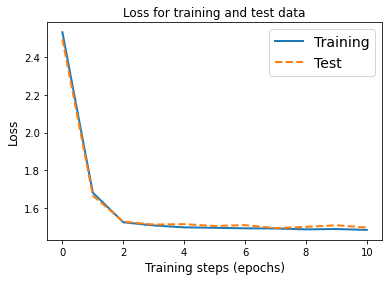

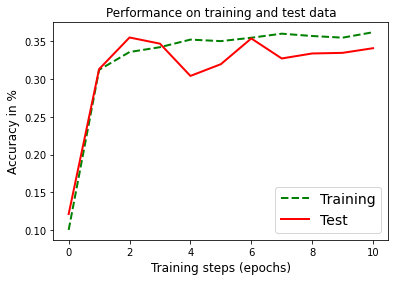

In [ ]:
# Visualize loss and accuracy for training and test data. 
# One plot for training and test loss.
plt.figure()
line1, = plt.plot(train_losses, linewidth = 2)
line2, = plt.plot(test_losses, linestyle = 'dashed', linewidth = 2)
plt.xlabel("Training steps (epochs)", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.legend((line1,line2),("Training","Test"), fontsize = 14)
plt.title("Loss for training and test data")
plt.show()
# One plot for training and test accuracy.
plt.figure()
line1, = plt.plot(train_accuracies, linestyle = 'dashed', color = 'green', linewidth = 2)
line2, = plt.plot(test_accuracies, color = 'red', linewidth = 2)
plt.xlabel("Training steps (epochs)", fontsize = 12)
plt.ylabel("Accuracy in %", fontsize = 12)
plt.legend((line1,line2),("Training","Test"), fontsize = 14)
plt.title("Performance on training and test data")
plt.show()


## Saving Model
Now that we have seen that our model performs pretty well, we might want to save all the parameters that it has learnt now and use it again later. For subclassed models you will need to use the function **save_weights()** and store it in a .h5 or .hdf5 format. 

In [ ]:
# Save the weights (or not the accuracy is not presentable)
model.save_weights('genomics_ood-35acc.h5')